# Homework 7 - Part B

*Note that there are two different notebooks for HW assignment 7. This is part A. There will be two different assignments in gradescope for each part. The deadlines are the same for both parts.*

## References

+ Lectures 27-28 (inclusive).


## Instructions

+ Type your name and email in the "Student details" section below.
+ Develop the code and generate the figures you need to solve the problems using this notebook.
+ For the answers that require a mathematical proof or derivation you should type them using latex. If you have never written latex before and you find it exceedingly difficult, we will likely accept handwritten solutions.
+ The total homework points are 100. Please note that the problems are not weighed equally.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

import scipy
import scipy.stats as st
import urllib.request
import os

def download(
    url : str,
    local_filename : str = None
):
    """Download a file from a url.
    
    Arguments
    url            -- The url we want to download.
    local_filename -- The filemame to write on. If not
                      specified 
    """
    if local_filename is None:
        local_filename = os.path.basename(url)
    urllib.request.urlretrieve(url, local_filename)

In [2]:
# Run this on Google colab
!pip install pyro-ppl

DEPRECATION: graphql-ws 0.3.0 has a non-standard dependency specifier graphql-core>=2.0<3. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of graphql-ws or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [3]:
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS
import torch

## Problem 1  - Bayesian Linear regression on steroids 

The purpose of this problem is to demonstrate that we have learned enough to do very complicated things.
In the first part, we will do Bayesian linear regression with radial basis functions (RBFs) in which we characterize the posterior of all parameters, including the length-scales of the RBFs.
In the second part, we are going to build a model that has an input-varying noise. Such models are called heteroscedastic models. 

We need to write some `pytorch` code to compute the design matrix. This is absolutely necessary so that `pyro` can differentiate through all expressions.

In [4]:
class RadialBasisFunctions(torch.nn.Module):
    """Radial basis functions basis.
    
    Arguments:
    X   -  The centers of the radial basis functions.
    ell -  The assumed length scale.
    """
    def __init__(self, X, ell):
        super().__init__()
        self.X = X
        self.ell = ell
        self.num_basis = X.shape[0]
    def forward(self, x):
        distances = torch.cdist(x, self.X)
        return torch.exp(-.5 * distances ** 2 / self.ell ** 2)

Here is how you can use them:

In [5]:
# Make the basis
x_centers = torch.linspace(-1, 1, 10).unsqueeze(-1)
ell = 0.2
basis = RadialBasisFunctions(x_centers, ell)

# Some points (need to be N x 1)
x = torch.linspace(-1, 1, 100).unsqueeze(-1)

# Evaluate the basis
Phi = basis(x)

# Here is the shape of Phi
print(Phi.shape)

torch.Size([100, 10])


Here is how they look like:

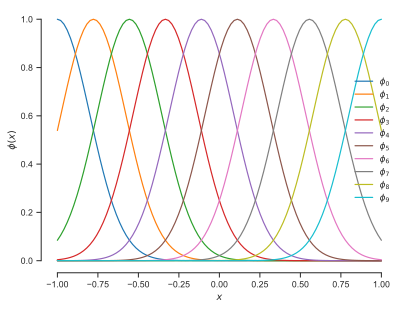

In [6]:
fig, ax = plt.subplots()
for i in range(Phi.shape[1]):
    ax.plot(x, Phi[:, i], label=f"$\phi_{i}$")
ax.set(xlabel="$x$", ylabel="$\phi(x)$")
ax.legend(loc="best", frameon=False)
sns.despine(trim=True);

### Part A - Hierarchical Bayesian linear regression with input-independent noise

We will analyze the motorcycle dataset. The data is loaded below.

In [7]:
url = "https://github.com/PredictiveScienceLab/data-analytics-se/raw/master/lecturebook/data/motor.dat"
download(url)

We will work with the scaled data:

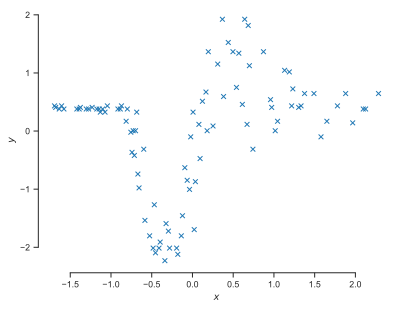

In [8]:
from sklearn.preprocessing import StandardScaler

data = np.loadtxt('motor.dat')
scaler = StandardScaler()
data = scaler.fit_transform(data)
X = torch.tensor(data[:, 0], dtype=torch.float32).unsqueeze(-1)
Y = torch.tensor(data[:, 1], dtype=torch.float32)

fig, ax = plt.subplots()
ax.plot(X, Y, 'x')
ax.set(xlabel="$x$", ylabel="$y$")
sns.despine(trim=True);

### Part A.I

Your goal is to implement the model described below.
We use the radial basis functions (`RadialBasisFunction`) with centers, $x_i$ at $m=50$ equidistant points between the minimum and maximum of the observed inputs:

$$
\phi_i(x;\ell) = \exp \left( - \frac{(x - x_i)^2}{2 \ell^2} \right),
$$

for $i=1,\dots,m$.
We denote the vector of RBFs evaluated at $x$ as $\boldsymbol{\phi}(x;\ell)$.

We are not going to pick the length-scales $\ell$ by hand. Instead, we will put a prior on it:

$$
\ell \sim \text{Exponential}(1).
$$

The corresponding weights have priors:

$$
w_j | \alpha_i \sim N(0, \alpha_j^2),
$$

and its $\alpha_j$ has a prior:

$$
\alpha_j \sim \text{Exponential}(1),
$$

for $j=1,\dots,m$.

Denote our data as:

$$
x_{1:n} = (x_1, \dots, x_n)^T,\;\text{(inputs)},
$$

and

$$
y_{1:n} = (y_1, \dots, y_n)^T,\;\text{(outputs)}.
$$

The likelihood of the data is:

$$
y_i | \mathbf{w}, \sigma \sim N(\mathbf{w}^T \boldsymbol{\phi}(x_i;\ell), \sigma^2),
$$

for $i=1,\dots,n$.

$$
y_n | \ell, \mathbf{w}, \sigma \sim N(\mathbf{w}^T \boldsymbol{\phi}(x_n;\ell), \sigma^2).
$$

Complete the `pyro` implementation of that model:

**Answer:**

In [9]:
def model(X, y, num_centers=50):
    with pyro.plate("centers", num_centers):
        alpha = pyro.sample("alpha", dist.Exponential(1.0))
        w = pyro.sample("w", dist.Normal(0.0, alpha))
    ell = pyro.sample("ell", dist.Exponential(1.))
    sigma = pyro.sample("sigma", dist.Exponential(1.))
    x_centers = torch.linspace(X.min(), X.max(), num_centers).unsqueeze(-1)
    Phi = RadialBasisFunctions(x_centers, ell)(X)
    with pyro.plate("data", X.shape[0]):
        pyro.sample("y", dist.Normal(Phi @ w, sigma), obs=y)
    return locals()

The graph will help to understand the model:

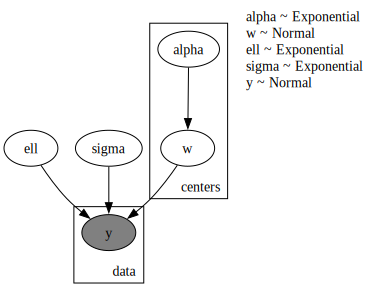

In [10]:
pyro.render_model(model, (X, Y), render_distributions=True)

Use `pyro.infer.autoguide.AutoDiagonalNormal` to make the guide:

In [11]:
guide = pyro.infer.autoguide.AutoDiagonalNormal(model)

We will use variational inference. Here is the training code from the hans-on activity:

In [12]:
def train(model, guide, data, num_iter=5_000):
    """Train a model with a guide.

    Arguments
    ---------
    model    -- The model to train.
    guide    -- The guide to train.
    data     -- The data to train the model with.
    num_iter -- The number of iterations to train.
    
    Returns
    -------
    elbos -- The ELBOs for each iteration.
    param_store -- The parameters of the model.
    """

    pyro.clear_param_store()

    optimizer = pyro.optim.Adam({"lr": 0.001})

    svi = pyro.infer.SVI(
        model,
        guide,
        optimizer,
        loss=pyro.infer.JitTrace_ELBO()
    )

    elbos = []
    for i in range(num_iter):
        loss = svi.step(*data)
        elbos.append(-loss)
        if i % 1_000 == 0:
            print(f"Iteration: {i} Loss: {loss}")

    return elbos, pyro.get_param_store()

### Part A.II

Train the model for 20,000 iterations:

In [13]:
elbos, params = train(model, guide, (X, Y), num_iter=20_000)

Iteration: 0 Loss: 306.9549255371094
Iteration: 1000 Loss: 198.59921264648438
Iteration: 2000 Loss: 158.4862518310547
Iteration: 3000 Loss: 126.88764190673828
Iteration: 4000 Loss: 119.8980712890625
Iteration: 5000 Loss: 131.83802795410156
Iteration: 6000 Loss: 122.84017944335938
Iteration: 7000 Loss: 130.41909790039062
Iteration: 8000 Loss: 131.00253295898438
Iteration: 9000 Loss: 132.89105224609375
Iteration: 10000 Loss: 128.07919311523438
Iteration: 11000 Loss: 127.1993408203125
Iteration: 12000 Loss: 149.5709228515625
Iteration: 13000 Loss: 133.2704620361328
Iteration: 14000 Loss: 124.64405059814453
Iteration: 15000 Loss: 129.1461639404297
Iteration: 16000 Loss: 139.90809631347656
Iteration: 17000 Loss: 112.9310531616211
Iteration: 18000 Loss: 128.1428680419922
Iteration: 19000 Loss: 134.82691955566406


### Part A.III

Plot the evolution of the ELBO:

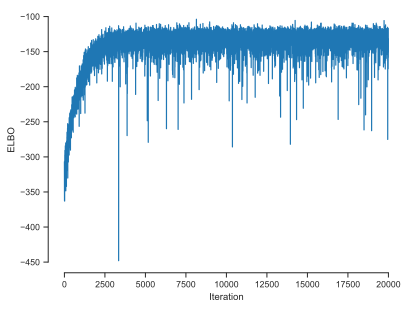

In [14]:
fig, ax = plt.subplots()
ax.plot(elbos)
ax.set(xlabel="Iteration", ylabel="ELBO")
sns.despine(trim=True);

### Part A.IV

Take 1,000 posterior samples:

In [15]:
post_samples = pyro.infer.Predictive(model, guide=guide, num_samples=1000)(X, Y)

### Part A.V

Plot the histograms of the posteriors of $\ell$, $\sigma$, $\alpha_10$ and $w_{10}$:

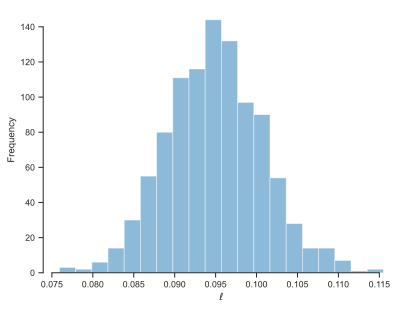

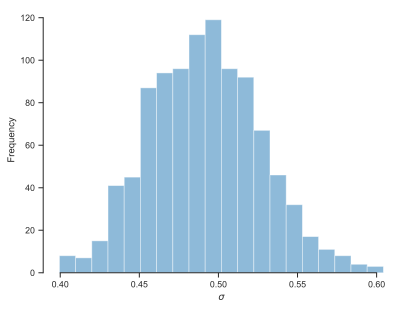

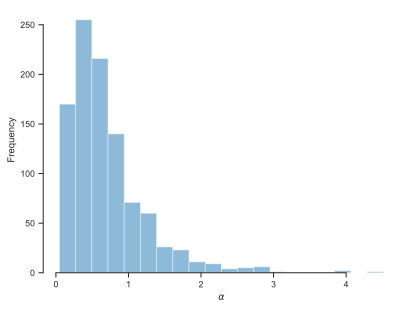

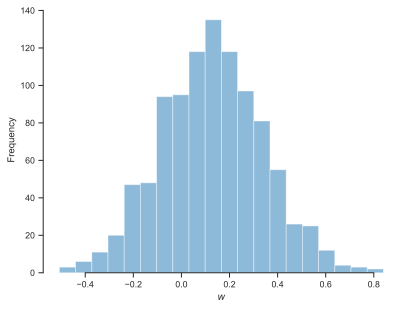

In [16]:
ell = post_samples["ell"]
alphas = post_samples["alpha"]
sigma = post_samples["sigma"]
ws = post_samples["w"]

fig, ax = plt.subplots()
# remember, you have to detach the tensor from the graph
ax.hist(ell.detach().numpy(), bins=20, alpha=.5)
ax.set(xlabel="$\ell$", ylabel="Frequency")
sns.despine(trim=True);

fig, ax = plt.subplots()
ax.hist(sigma.detach().numpy(), bins=20, alpha=.5)
ax.set(xlabel="$\sigma$", ylabel="Frequency")
sns.despine(trim=True);

fig, ax = plt.subplots()
ax.hist(alphas[:, 9].detach().numpy(), bins=20, alpha=.5)
ax.set(xlabel="$\\alpha$", ylabel="Frequency")
sns.despine(trim=True);

fig, ax = plt.subplots()
ax.hist(ws[:, 9].detach().numpy(), bins=20, alpha=.5)
ax.set(xlabel="$w$", ylabel="Frequency")
sns.despine(trim=True);

### Part A.VI

Let's extend them model to make predictions:

In [17]:
def predictive_model(X, y, num_centers=50):
    params = model(X, y, num_centers)
    w = params["w"]
    ell = params["ell"]
    sigma = params["sigma"]
    x_centers = params["x_centers"]
    xs = torch.linspace(X.min(), X.max(), 100).unsqueeze(-1)
    Phi = RadialBasisFunctions(x_centers, ell)(xs)
    predictions = pyro.deterministic("predictions", Phi @ w)
    predictions_with_noise = pyro.sample("predictions_with_noise", dist.Normal(predictions, sigma))
    return locals()

### Part A.VII

Extract the posterior predictive distribution, separate aleatory and epistemic uncertainty.

In [18]:
post_pred = pyro.infer.Predictive(predictive_model, guide=guide, num_samples=10_000)(X, Y)

xs = torch.linspace(X.min(), X.max(), 100).unsqueeze(-1)
predictions = post_pred["predictions"]
# epistemic uncertainty
p_500, p_025, p_975 = np.percentile(predictions, [50, 2.5, 97.5], axis=0)
# aleatory uncertainty
ap_025, ap_975 = np.percentile(post_pred["predictions_with_noise"], [2.5, 97.5], axis=0)

### Part A.VIII

Plot the data, the median, the 95% credible interval of epistemic uncertainty and the 95% credible interval of aleatory uncertainty, along with five samples from the posterior:

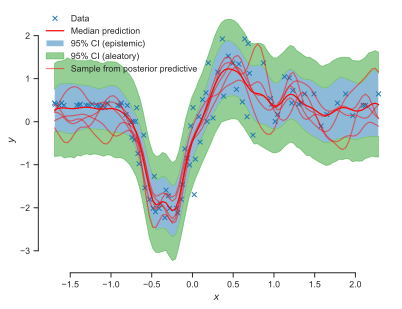

In [19]:
fig, ax = plt.subplots()
ax.plot(X, Y, 'x', label="Data")
ax.plot(xs, p_500.flatten(), 'r', label="Median prediction")
ax.fill_between(xs.squeeze(), p_025.flatten(), p_975.flatten(), alpha=.5, label="95% CI (epistemic)")
ax.fill_between(xs.squeeze(), ap_025.flatten(), p_025.flatten(), alpha=.5, label="95% CI (aleatory)",
                color=sns.color_palette()[2])
ax.fill_between(xs.squeeze(), p_975.flatten(), ap_975.flatten(), alpha=.5, color=sns.color_palette()[2])
for i in range(5):
    ax.plot(xs, predictions[i, 0, :], 'r', alpha=.5, label="Sample from posterior predictive" if i == 0 else None)
ax.set(xlabel="$x$", ylabel="$y$")
plt.legend(loc="best", frameon=False)
sns.despine(trim=True);


### Part B - Heteroscedastic regression

We are going to build a model that has an input-varying noise. Such models are called heteroscedastic models.

Everything is as before for $\ell$, the $\alpha_j$'s, and the $w_j$'s.
We now introduce a model for the noise that is input dependent.
It will use the same RBFs as the mean function.
But let's use a different length-scale, $\ell_\sigma$.
So, we add:

$$
\ell_\sigma \sim \text{Exponential}(1),
$$

$$
\alpha_{\sigma,j} \sim \text{Exponential}(1),
$$

and

$$
w_{\sigma,j} | \alpha_{\sigma,j} \sim N(0, \alpha_{\sigma,j}^2),
$$

for $j=1,\dots,m$.

Our model for the input-dependent noise variance is:

$$
\sigma^2(x;\mathbf{w}_\sigma,\ell) = \exp\left(\mathbf{w}_\sigma^T \boldsymbol{\phi}(x;\ell_\sigma)\right).
$$

So, the likelihood of the data is:

$$
y_i | \mathbf{w}, \mathbf{w}_\sigma \sim N\left(\mathbf{w}^T \boldsymbol{\phi}(x_i;\ell), \sigma^2(x_i;\mathbf{w}_\sigma,\ell)\right),
$$

You will implement this model.

### Part B.I

Complete the code below:

In [20]:
def model(X, y, num_centers=50):
    with pyro.plate("centers", num_centers):
        alpha = pyro.sample("alpha", dist.Exponential(1.0))
        w = pyro.sample("w", dist.Normal(0.0, alpha))
        # This is the new part 1/2
        alpha_noise = pyro.sample("alpha_noise", dist.Exponential(1.0))
        w_noise = pyro.sample("v", dist.Normal(0.0, alpha_noise))
    ell = pyro.sample("ell", dist.Exponential(1.))
    ell_noise = pyro.sample("ell_noise", dist.Exponential(1.))
    x_centers = torch.linspace(X.min(), X.max(), num_centers).unsqueeze(-1)
    Phi = RadialBasisFunctions(x_centers, ell)(X)
    Phi_noise = RadialBasisFunctions(x_centers, ell_noise)(X)
    # This is the new part 2/2
    sigma2 = torch.exp(Phi_noise @ w_noise)
    with pyro.plate("data", X.shape[0]):
        pyro.sample("y", dist.Normal(Phi @ w, sigma2), obs=y)
    return locals()

Make a `pyro.infer.autoguide.AutoDiagonalNormal` guide:

In [21]:
guide = pyro.infer.autoguide.AutoDiagonalNormal(model)

### Part B.II

Train the model:

In [22]:
elbos, params = train(model, guide, (X, Y), num_iter=20_000);

Iteration: 0 Loss: 522.2918090820312
Iteration: 1000 Loss: 321.7183532714844
Iteration: 2000 Loss: 234.402587890625
Iteration: 3000 Loss: 214.80059814453125
Iteration: 4000 Loss: 186.92056274414062
Iteration: 5000 Loss: 175.38336181640625
Iteration: 6000 Loss: 182.92616271972656
Iteration: 7000 Loss: 203.57090759277344
Iteration: 8000 Loss: 186.22206115722656
Iteration: 9000 Loss: 185.53469848632812
Iteration: 10000 Loss: 174.5776824951172
Iteration: 11000 Loss: 183.88938903808594
Iteration: 12000 Loss: 159.54046630859375
Iteration: 13000 Loss: 167.87606811523438
Iteration: 14000 Loss: 169.49044799804688
Iteration: 15000 Loss: 146.07852172851562
Iteration: 16000 Loss: 143.02088928222656
Iteration: 17000 Loss: 180.70095825195312
Iteration: 18000 Loss: 183.29190063476562
Iteration: 19000 Loss: 185.24440002441406


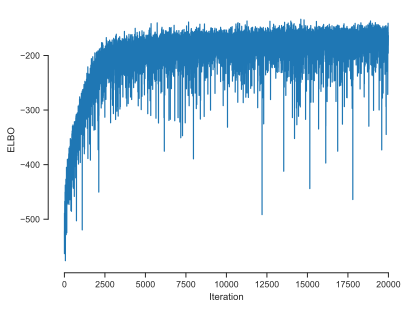

In [23]:
fig, ax = plt.subplots()
ax.plot(elbos)
ax.set(xlabel="Iteration", ylabel="ELBO")
sns.despine(trim=True);

### Part B.III

Extend the model to make predictions:

In [30]:
def predictive_model(X, y, num_centers=50):
    params = model(X, y, num_centers)
    w = params["w"]
    w_noise = params["w_noise"]
    ell = params["ell"]
    ell_noise = params["ell_noise"]
    x_centers = params["x_centers"]
    xs = torch.linspace(X.min(), X.max(), 100).unsqueeze(-1)
    Phi = RadialBasisFunctions(x_centers, ell)(xs)
    Phi_noise = RadialBasisFunctions(x_centers, ell_noise)(xs)
    predictions = pyro.deterministic("predictions", Phi @ w)
    sigma = pyro.deterministic("sigma", torch.exp(Phi_noise @ w_noise))
    predictions_with_noise = pyro.sample("predictions_with_noise", dist.Normal(predictions, sigma))
    return locals()

### Part B.IV

Now, make predictions and calculate the epistemic and aleatory uncertainties:

In [31]:
post_pred = pyro.infer.Predictive(predictive_model, guide=guide, num_samples=1_000)(X, Y)

xs = torch.linspace(X.min(), X.max(), 100).unsqueeze(-1)
predictions = post_pred["predictions"]
# epistemic uncertainty
p_500, p_025, p_975 = np.percentile(predictions, [50, 2.5, 97.5], axis=0)
# aleatory uncertainty
ap_025, ap_975 = np.percentile(post_pred["predictions_with_noise"], [2.5, 97.5], axis=0)

### Part B.V

Finally, make the usual plot:

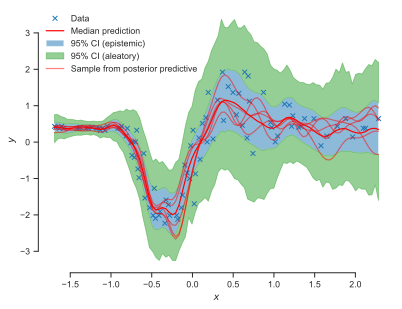

In [32]:
fig, ax = plt.subplots()
ax.plot(X, Y, 'x', label="Data")
ax.plot(xs, p_500.flatten(), 'r', label="Median prediction")
ax.fill_between(xs.squeeze(), p_025.flatten(), p_975.flatten(), alpha=.5, label="95% CI (epistemic)")
ax.fill_between(xs.squeeze(), ap_025.flatten(), p_025.flatten(), alpha=.5, label="95% CI (aleatory)",
                color=sns.color_palette()[2])
ax.fill_between(xs.squeeze(), p_975.flatten(), ap_975.flatten(), alpha=.5, color=sns.color_palette()[2])
for i in range(5):
    ax.plot(xs, predictions[i, 0, :], 'r', alpha=.5, label="Sample from posterior predictive" if i == 0 else None)
ax.set(xlabel="$x$", ylabel="$y$")
plt.legend(loc="best", frameon=False)
sns.despine(trim=True);

### Part B.VI

Plot the estimated noise standard deviation as a function of of the input along with a 95% credible interval.

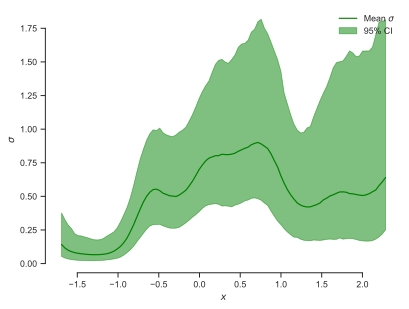

In [40]:
sigma = post_pred["sigma"]
sigma_500, sigma_025, sigma_975 = np.percentile(sigma, [50, 2.5, 97.5], axis=0)
fig, ax = plt.subplots()
ax.plot(xs, sigma_500.flatten(), 'g', label="Mean $\sigma$")
ax.fill_between(xs.squeeze(), sigma_025.flatten(), sigma_975.flatten(), alpha=.5, label="95% CI", color="g")
ax.set(xlabel="$x$", ylabel="$\sigma$")
plt.legend(loc="best", frameon=False)
sns.despine(trim=True);

### Part B.VII

Which model do you prefer? Why?

**Answer:**
<br><br><br><br><br><br><br><br><br><br><br><br><br><br>

### Part B.IX

Can you think of any way to improve the model?
Go crazy! This is the last homework assignment!
There is no right or wrong answer here.
But if you have a good idea, we will give you extra credit.

In [ ]:
## Your code and answers here